# Generate 3d Binary Choice data

In [1]:
import os
import numpy as np
from scipy.stats import multivariate_normal
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from plnn.models.algebraic_pl import AlgebraicPL

In [2]:
# plt.rcParams['font.size'] = 10
plt.style.use("../figures/manuscript/styles/fig_standard.mplstyle")

In [3]:
LIGHT_CORAL = '#FF8888'
CORAL = '#EE3377'
LIGHT_RED = '#FF6666'
RED = '#CC3311'
DARK_RED = '#990000'

LIGHT_GREEN = '#99FF99'
GREEN = '#66CC66'
DARK_GREEN = '#339933'

LIGHT_TEAL = '#99DDFF'
TEAL = '#33BBCC'
LIGHT_BLUE = '#66B2FF'
BLUE = '#005599'


REDS = [LIGHT_CORAL, LIGHT_RED, DARK_RED]
GREENS = [LIGHT_GREEN, GREEN, DARK_GREEN]
BLUES = [LIGHT_TEAL, TEAL, BLUE]

COLOR_TRIPLES = [
    REDS,
    GREENS,
    BLUES,
]

COLS = [REDS[-1], BLUES[-1], GREENS[-1]]


CMAP1 = LinearSegmentedColormap.from_list(
    'custom_map1', [(r, c) for r, c in zip([0, 0.5, 1.0], REDS)]
)
CMAP2 = LinearSegmentedColormap.from_list(
    'custom_map2', [(r, c) for r, c in zip([0, 0.5, 1.0], BLUES)]
)
CMAP3 = LinearSegmentedColormap.from_list(
    'custom_map3', [(r, c) for r, c in zip([0, 0.5, 1.0], GREENS)]
)

In [4]:
seed = 42
rng = np.random.default_rng(seed=seed)
key = jrandom.PRNGKey(rng.integers(2**32))
print(key)

[        0 383329928]


In [5]:
OUTDIR = "out/syndata_bc_3d"
out_traindir = f"{OUTDIR}/data/training"
out_validdir = f"{OUTDIR}/data/validation"
os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(out_traindir, exist_ok=True)
os.makedirs(out_validdir, exist_ok=True)

In [6]:
NSIMS = 3

SIGMA = 0.4

RHO = 3
ETA = 0.1

VIEW_INIT = [32, 142]

TRAINED_MODEL_DIR = "../data/trained_models/misc/model_miniset1_v1_20240814_164134"

In [7]:
sf = 1/2.54
FIGSIZE = None

In [8]:
key, subkey = jrandom.split(key, 2)
model, _ = AlgebraicPL.make_model(
    key=subkey,
    dtype=jnp.float64,
    algebraic_phi_id="phi1",
    tilt_weights=[[1, 0],[0, 1]],
    tilt_bias=[0, 0],
    sigma_init=SIGMA,
    signal_type="sigmoid",
    nsigparams=4,
)

In [9]:
# Simulation parameters

ncells = 100
x0_val = (0.0, -0.5)
tfin = 6
burnin = 0.2
burnin_signal = (0, 1)
dtsave1 = 0.1
dtsave2 = 2.


# Signal profiles
rate1 = 1
rate2 = 1
rate3 = 1

sigparams1 = [
    [1.50, 0, -0.50, rate1], 
    [1.75, 1, -0.25, rate1],
]
sigparams2 = [
    [1.25, 0,  0.75, rate2], 
    [1.75, 1, -0.50, rate2],
]
sigparams3 = [
    [1.25, 0, -0.10, rate3], 
    [1.75, 1, -0.50, rate3],
]

SIGPARAMS_LIST = [
    sigparams1, 
    sigparams2, 
    sigparams3,
]

In [10]:
XS_RESULTS = []
for cond_idx, sigparams in enumerate(SIGPARAMS_LIST):
    sigparams = jnp.array(sigparams, dtype=jnp.float64)

    # Initial condition
    key, subkey = jrandom.split(key, 2)
    x0 = np.zeros([ncells, 2])
    x0[:] = x0_val

    # Simulate particles in the landscape
    key, subkey = jrandom.split(key, 2)
    ts_all, xys_all, sigs_all, ps_all = model.run_landscape_simulation(
        x0, tfin, [dtsave1, dtsave2], sigparams, subkey, 
        burnin=burnin
    )

    ts, ts_saved = ts_all
    xys, xys_saved = xys_all
    sigs, sigs_saved = sigs_all
    ps, ps_saved = ps_all

    zs_saved = np.sqrt(RHO**2 - xys_saved[...,0]**2 - xys_saved[...,1]**2)
    zs_saved += ETA * rng.standard_normal(zs_saved.shape)
    
    xyzs_saved = np.zeros(xys_saved.shape[0:-1] + (3,))
    xyzs_saved[...,0:2] = xys_saved
    xyzs_saved[...,-1] = zs_saved
    XS_RESULTS.append(xyzs_saved)

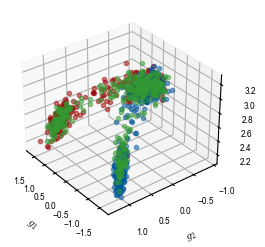

In [11]:
# %matplotlib widget
figsize = (8*sf, 6*sf)
fig = plt.figure(figsize=figsize, layout='constrained')
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(*VIEW_INIT)

colors = COLS

legend_handles = []
legend_labels = []
for cond_idx, xyz_across_times in enumerate(XS_RESULTS):
    for xyz in xyz_across_times:
        sc, = ax.plot(
            xyz[:,0], xyz[:,1], xyz[:,2], '.', 
            color=colors[cond_idx],
            alpha=0.5,
        )
    legend_handles.append(sc)
    legend_labels.append(f"Exp. {cond_idx+1}")

ax.set_xlabel("$g_1$")
ax.set_ylabel("$g_2$")
# ax.set_zlabel("$g_3$")
# ax.legend(
    # legend_handles, legend_labels, 
    # bbox_to_anchor=(0.9, 1), loc='upper left',
    # fontsize='small',
# )

xlims = ax.get_xlim()
ylims = ax.get_ylim()
zlims = ax.get_zlim()

plt.savefig(f"{OUTDIR}/data_combined.pdf", bbox_inches='tight', pad_inches=0.2, transparent=True)

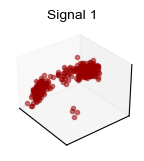

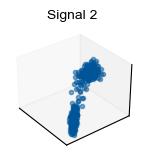

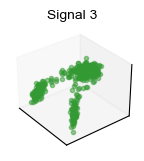

In [12]:
figsize = (1.5, 1.5)
colors = COLS
for cond_idx, xyz_across_times in enumerate(XS_RESULTS):
    fig = plt.figure(figsize=figsize, layout='constrained')
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.view_init(*VIEW_INIT)

    for xyz in xyz_across_times:
        ax.plot(
            xyz[:,0], xyz[:,1], xyz[:,2], '.', 
            color=colors[cond_idx],
            alpha=0.5,
        )

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    # ax.set_xlabel("$g_1$")
    # ax.set_ylabel("$g_2$")
    # ax.set_zlabel("$g_3$")
    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)
    ax.set_zlim(*zlims)
    ax.set_title(f"Signal {cond_idx+1}")
    plt.savefig(f"{OUTDIR}/data_cond_{cond_idx+1}.pdf", bbox_inches='tight', pad_inches=0.3, transparent=True)
    


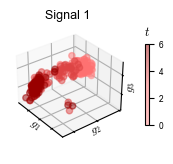

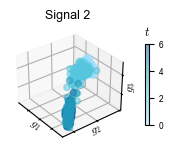

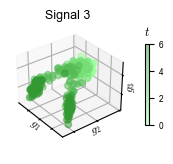

In [13]:
figsize = (2.5, 1.5)

cmaps = [CMAP1, CMAP2, CMAP3]

for cond_idx, xyz_across_times in enumerate(XS_RESULTS):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.view_init(*VIEW_INIT)

    for t, xyz in zip(ts_saved, xyz_across_times):

        sc = ax.scatter(
            xyz[:,0], xyz[:,1], xyz[:,2], '.', 
            c = t * np.ones(xyz.shape[0]),
            cmap=cmaps[cond_idx],
            vmin=ts_saved[0],
            vmax=ts_saved[-1],
            alpha=0.5,
        )

    ax.set_xlabel("$g_1$", labelpad=-17)
    ax.set_ylabel("$g_2$", labelpad=-17)
    ax.set_zlabel("$g_3$", labelpad=-17)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)
    ax.set_zlim(*zlims)
    ax.set_title(f"Signal {cond_idx+1}", fontsize=9)
    
    cbar = fig.colorbar(sc, ax=ax, pad=0.1, orientation='vertical', shrink=0.7)
    cbar.ax.set_title("$t$", fontsize=9)
    cbar.ax.set_yticks(ts_saved) 

    plt.savefig(f"{OUTDIR}/data_tshaded_cond_{cond_idx+1}.pdf", bbox_inches='tight')

In [14]:
xdata_all = np.array(XS_RESULTS).reshape([-1, 3])

In [15]:
from sklearn.mixture import GaussianMixture

NCOMPS = 3

gmm = GaussianMixture(n_components=NCOMPS)
gmm.fit(xdata_all)

GaussianMixture(n_components=3)

In [16]:
CONTOUR_ALPHA = 1.0
CONTOUR_LEVELS = [0.95, 0.75, 0.5]  # plot level sets of GMMs at alpha level

COMPONENT_COLORS = [
    'purple', 'cyan', 'orange'
]

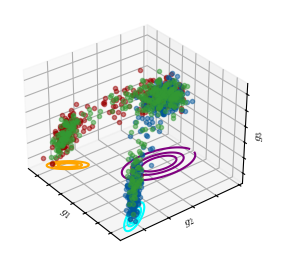

In [17]:
# %matplotlib widget
figsize = (10*sf, 8*sf)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(*VIEW_INIT)

for comp_idx in range(NCOMPS):
    mean = gmm.means_[comp_idx]
    cov = gmm.covariances_[comp_idx]
    mvn = multivariate_normal(mean=mean[0:2], cov=cov[0:2,0:2])
    xarr = np.linspace(*xlims, 100)
    yarr = np.linspace(*ylims, 100)
    xs, ys = np.meshgrid(xarr, yarr)
    pos = np.dstack([xs, ys])
    zs = mvn.pdf(pos)
    alpha_levels = np.array(CONTOUR_LEVELS)
    c = -2*np.log(1 - alpha_levels)
    levels = np.exp(-c/2) / (2*np.pi*np.sqrt(np.linalg.det(mvn.cov)))
    col = COMPONENT_COLORS[comp_idx]
    ax.contour(
        xs, ys, zs,
        levels=np.sort(levels),
        zdir='z',
        offset=zlims[0],
        colors=[col],
        alpha=CONTOUR_ALPHA,
    )


colors = COLS
legend_handles = []
legend_labels = []
for cond_idx, xyz_across_times in enumerate(XS_RESULTS):
    for xyz in xyz_across_times:
        sc, = ax.plot(
            xyz[:,0], xyz[:,1], xyz[:,2], '.', 
            color=colors[cond_idx],
            alpha=0.5,
            zorder=6,
        )
    legend_handles.append(sc)
    legend_labels.append(f"Exp. {cond_idx+1}")

ax.set_xlabel("$g_1$", labelpad=-15)
ax.set_ylabel("$g_2$", labelpad=-15)
ax.set_zlabel("$g_3$", labelpad=-15)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
# ax.legend(legend_handles, legend_labels)

ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
ax.set_zlim(*zlims)

plt.savefig(f"{OUTDIR}/data_combined_clustered.pdf", bbox_inches='tight', pad_inches=0.2, transparent=True)

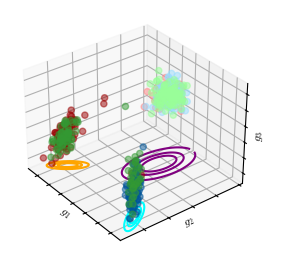

In [18]:
# %matplotlib widget
figsize = (10*sf, 8*sf)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(*VIEW_INIT)

for comp_idx in range(NCOMPS):
    mean = gmm.means_[comp_idx]
    cov = gmm.covariances_[comp_idx]
    mvn = multivariate_normal(mean=mean[0:2], cov=cov[0:2,0:2])
    xarr = np.linspace(*xlims, 100)
    yarr = np.linspace(*ylims, 100)
    xs, ys = np.meshgrid(xarr, yarr)
    pos = np.dstack([xs, ys])
    zs = mvn.pdf(pos)
    alpha_levels = np.array(CONTOUR_LEVELS)
    c = -2*np.log(1 - alpha_levels)
    levels = np.exp(-c/2) / (2*np.pi*np.sqrt(np.linalg.det(mvn.cov)))
    col = COMPONENT_COLORS[comp_idx]
    ax.contour(
        xs, ys, zs,
        levels=np.sort(levels),
        zdir='z',
        offset=zlims[0],
        colors=[col],
        alpha=CONTOUR_ALPHA,
    )

# cmaps = [
#     LinearSegmentedColormap.from_list(
#         'custom_reds', [(0, 'lightcoral'), (1, 'red')]
#     ),
#     LinearSegmentedColormap.from_list(
#         'custom_blues', [(0, 'lightblue'), (1, 'blue')]
#     ),
#     LinearSegmentedColormap.from_list(
#         'custom_greens', [(0, 'lightgreen'), (1, 'green')]
#     ),
# ]
cmaps = [CMAP1, CMAP2, CMAP3]
legend_handles = []
legend_labels = []
for cond_idx, xyz_across_times in enumerate(XS_RESULTS):
    for t, xyz in zip([ts_saved[0], ts_saved[-1]], 
                       [xyz_across_times[0], xyz_across_times[-1]]):
        sc = ax.scatter(
            xyz[:,0], xyz[:,1], xyz[:,2], '.', 
            c = t * np.ones(xyz.shape[0]),
            cmap=cmaps[cond_idx],
            vmin=ts_saved[0],
            vmax=ts_saved[-1],
            alpha=0.5,
        )
        legend_handles.append(sc)
        legend_labels.append(f"Exp. {cond_idx+1}, t={t:n}"),

ax.set_xlabel("$g_1$", labelpad=-15)
ax.set_ylabel("$g_2$", labelpad=-15)
ax.set_zlabel("$g_3$", labelpad=-15)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
# ax.legend(
#     legend_handles, legend_labels, 
#     bbox_to_anchor=(0.75, 1.2), loc='upper left',
#     fontsize='small',
# )

ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
ax.set_zlim(*zlims)
plt.savefig(f"{OUTDIR}/data_endpoints_clustered.pdf", bbox_inches='tight', pad_inches=0.2, transparent=True)

In [19]:
# Apply PCA

from sklearn.decomposition import PCA

xs_endpoints = np.array([XS_RESULTS[0], XS_RESULTS[-1]])
xdata_endpoints = xs_endpoints.reshape([-1, 3])

mu_xdata_endpoints = xdata_endpoints.mean(axis=0)

pca = PCA(n_components=3)
pca.fit(xdata_endpoints)

xdata_endpoints_trans = pca.transform(xdata_endpoints)
uvw_endpoints = xdata_endpoints_trans.reshape(np.shape(xs_endpoints))

In [20]:
# Compute the plane

pc1 = pca.components_[0]
pc2 = pca.components_[1]

normal = np.cross(pc1, pc2)
d = np.dot(normal, mu_xdata_endpoints)
plane_eq = lambda x, y: (d - normal[0]*x - normal[1]*y) / normal[2]

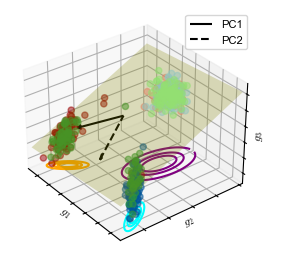

In [21]:
# Plot plane
figsize = (10*sf, 8*sf)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(*VIEW_INIT)

for comp_idx in range(NCOMPS):
    mean = gmm.means_[comp_idx]
    cov = gmm.covariances_[comp_idx]
    mvn = multivariate_normal(mean=mean[0:2], cov=cov[0:2,0:2])
    xarr = np.linspace(*xlims, 100)
    yarr = np.linspace(*ylims, 100)
    xs, ys = np.meshgrid(xarr, yarr)
    pos = np.dstack([xs, ys])
    zs = mvn.pdf(pos)
    alpha_levels = np.array(CONTOUR_LEVELS)
    c = -2*np.log(1 - alpha_levels)
    levels = np.exp(-c/2) / (2*np.pi*np.sqrt(np.linalg.det(mvn.cov)))
    col = COMPONENT_COLORS[comp_idx]
    ax.contour(
        xs, ys, zs,
        levels=np.sort(levels),
        zdir='z',
        offset=zlims[0],
        colors=[col],
        alpha=CONTOUR_ALPHA,
    )

# cmaps = [
#     LinearSegmentedColormap.from_list(
#         'custom_reds', [(0, 'lightcoral'), (1, 'red')]
#     ),
#     LinearSegmentedColormap.from_list(
#         'custom_blues', [(0, 'lightblue'), (1, 'blue')]
#     ),
#     LinearSegmentedColormap.from_list(
#         'custom_greens', [(0, 'lightgreen'), (1, 'green')]
#     ),
# ]
cmaps = [CMAP1, CMAP2, CMAP3]
legend_handles = []
legend_labels = []
for cond_idx, xyz_across_times in enumerate(XS_RESULTS):
    for t, xyz in zip([ts_saved[0], ts_saved[-1]], 
                       [xyz_across_times[0], xyz_across_times[-1]]):
        sc = ax.scatter(
            xyz[:,0], xyz[:,1], xyz[:,2], '.', 
            c = t * np.ones(xyz.shape[0]),
            cmap=cmaps[cond_idx],
            vmin=ts_saved[0],
            vmax=ts_saved[-1],
            alpha=0.5,
        )
        # legend_handles.append(sc)
        # legend_labels.append(f"Exp. {cond_idx+1}, t={t:n}")

# Plot surface
xarr = np.linspace(*xlims, 100)
yarr = np.linspace(*ylims, 100)
xs, ys = np.meshgrid(xarr, yarr)
pos = np.dstack([xs, ys])
zs = plane_eq(xs.flatten(), ys.flatten()).reshape(xs.shape)

ax.plot_surface(
    xs, ys, zs, 
    rstride=100, 
    cstride=100,
    alpha=0.25, 
    color='y'
)

# Plot PC directions
ax.quiver(
    *mu_xdata_endpoints, *pc1,
    color='k', alpha=1, lw=1.5, arrow_length_ratio=0.1, length=1,
    linestyle='-',
    label="PC1",
)
ax.quiver(
    *mu_xdata_endpoints, *pc2,
    color='k', alpha=1, lw=1.5, arrow_length_ratio=0.1, length=1,
    linestyle='--',
    label="PC2",
)
ax.legend()

# Plot arrows
arrow1_start = [*mu_xdata_endpoints[0:2], plane_eq(*mu_xdata_endpoints[0:2])]
arrow2_start = [*mu_xdata_endpoints[0:2], plane_eq(*mu_xdata_endpoints[0:2])]

ax.set_xlabel("$g_1$", labelpad=-15)
ax.set_ylabel("$g_2$", labelpad=-15)
ax.set_zlabel("$g_3$", labelpad=-15)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
ax.set_zlim(*zlims)

plt.savefig(f"{OUTDIR}/data_endpoints_clustered_pca_plane.pdf", pad_inches=0.25, transparent=True)

In [22]:
# Transform all of the data and plot projection on the plane
xdata_trans = pca.transform(xdata_all)
uvw_all = xdata_trans.reshape(np.shape(XS_RESULTS))

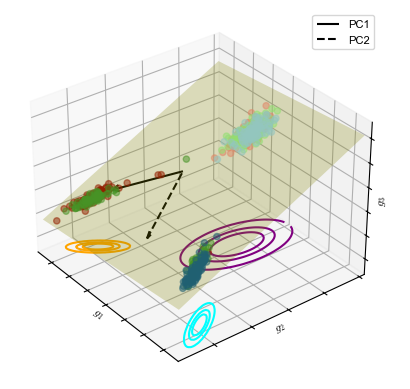

In [23]:
# %matplotlib widget
fig = plt.figure(figsize=FIGSIZE)
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(*VIEW_INIT)

for comp_idx in range(NCOMPS):
    mean = gmm.means_[comp_idx]
    cov = gmm.covariances_[comp_idx]
    mvn = multivariate_normal(mean=mean[0:2], cov=cov[0:2,0:2])
    xarr = np.linspace(*xlims, 100)
    yarr = np.linspace(*ylims, 100)
    xs, ys = np.meshgrid(xarr, yarr)
    pos = np.dstack([xs, ys])
    zs = mvn.pdf(pos)
    alpha_levels = np.array(CONTOUR_LEVELS)
    c = -2*np.log(1 - alpha_levels)
    levels = np.exp(-c/2) / (2*np.pi*np.sqrt(np.linalg.det(mvn.cov)))
    col = COMPONENT_COLORS[comp_idx]
    ax.contour(
        xs, ys, zs,
        levels=np.sort(levels),
        zdir='z',
        offset=zlims[0],
        colors=[col],
        alpha=CONTOUR_ALPHA,
    )

cmaps = [CMAP1, CMAP2, CMAP3]
legend_handles = []
legend_labels = []
for cond_idx, xyz_across_times in enumerate(XS_RESULTS):
    for t, xyz in zip([ts_saved[0], ts_saved[-1]], 
                       [xyz_across_times[0], xyz_across_times[-1]]):
        uv = pca.transform(xyz)[:,0:2]
        proj_xy = mu_xdata_endpoints[None,:] + uv @ np.array([pc1, pc2])
        z = plane_eq(proj_xy[:,0], proj_xy[:,1])
        sc = ax.scatter(
            proj_xy[:,0], proj_xy[:,1], z, '.', 
            c = t * np.ones(xyz.shape[0]),
            cmap=cmaps[cond_idx],
            vmin=ts_saved[0],
            vmax=ts_saved[-1],
            alpha=0.5,
        )
        # legend_handles.append(sc)
        # legend_labels.append(f"Exp. {cond_idx+1}, t={t:n}")

# Plot surface
xarr = np.linspace(*xlims, 100)
yarr = np.linspace(*ylims, 100)
xs, ys = np.meshgrid(xarr, yarr)
pos = np.dstack([xs, ys])
zs = plane_eq(xs.flatten(), ys.flatten()).reshape(xs.shape)

# Plot PC directions
q1 = ax.quiver(
    *mu_xdata_endpoints, *pc1,
    color='k', alpha=1, lw=1.5, arrow_length_ratio=0.1, length=1,
    linestyle='-',
    label="PC1",
)
q2 = ax.quiver(
    *mu_xdata_endpoints, *pc2,
    color='k', alpha=1, lw=1.5, arrow_length_ratio=0.1, length=1,
    linestyle='--',
    label="PC2",
)

ax.plot_surface(
    xs, ys, zs, 
    rstride=100, 
    cstride=100,
    alpha=0.25, 
    color='y'
)

ax.legend()

ax.set_xlabel("$g_1$", labelpad=-15)
ax.set_ylabel("$g_2$", labelpad=-15)
ax.set_zlabel("$g_3$", labelpad=-15)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
ax.set_zlim(*zlims)

plt.savefig(f"{OUTDIR}/endpoint_data_projected_pca_plane.pdf")

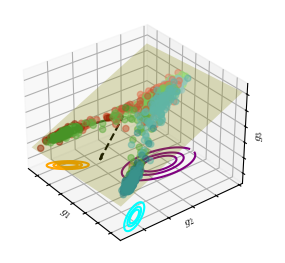

In [24]:
# %matplotlib widget
figsize = (10*sf, 8*sf)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(*VIEW_INIT)

for comp_idx in range(NCOMPS):
    mean = gmm.means_[comp_idx]
    cov = gmm.covariances_[comp_idx]
    mvn = multivariate_normal(mean=mean[0:2], cov=cov[0:2,0:2])
    xarr = np.linspace(*xlims, 100)
    yarr = np.linspace(*ylims, 100)
    xs, ys = np.meshgrid(xarr, yarr)
    pos = np.dstack([xs, ys])
    zs = mvn.pdf(pos)
    alpha_levels = np.array(CONTOUR_LEVELS)
    c = -2*np.log(1 - alpha_levels)
    levels = np.exp(-c/2) / (2*np.pi*np.sqrt(np.linalg.det(mvn.cov)))
    col = COMPONENT_COLORS[comp_idx]
    ax.contour(
        xs, ys, zs,
        levels=np.sort(levels),
        zdir='z',
        offset=zlims[0],
        colors=[col],
        alpha=CONTOUR_ALPHA,
    )

cmaps = [CMAP1, CMAP2, CMAP3]
legend_handles = []
legend_labels = []
for cond_idx, xyz_across_times in enumerate(XS_RESULTS):
    for t, xyz in zip(ts_saved, xyz_across_times):
        uv = pca.transform(xyz)[:,0:2]
        proj_xy = mu_xdata_endpoints[None,:] + uv @ np.array([pc1, pc2])
        z = plane_eq(proj_xy[:,0], proj_xy[:,1])
        sc = ax.scatter(
            proj_xy[:,0], proj_xy[:,1], z, '.', 
            c = t * np.ones(xyz.shape[0]),
            cmap=cmaps[cond_idx],
            vmin=ts_saved[0],
            vmax=ts_saved[-1],
            alpha=0.5,
        )
        # legend_handles.append(sc)
        # legend_labels.append(f"Exp. {cond_idx+1}, t={t:n}")

# Plot surface
xarr = np.linspace(*xlims, 100)
yarr = np.linspace(*ylims, 100)
xs, ys = np.meshgrid(xarr, yarr)
pos = np.dstack([xs, ys])
zs = plane_eq(xs.flatten(), ys.flatten()).reshape(xs.shape)

# Plot PC directions
ax.quiver(
    *mu_xdata_endpoints, *pc1,
    color='k', alpha=1, lw=1.5, arrow_length_ratio=0.1, length=1,
    linestyle='-',
)
ax.quiver(
    *mu_xdata_endpoints, *pc2,
    color='k', alpha=1, lw=1.5, arrow_length_ratio=0.1, length=1,
    linestyle='--',
)

ax.plot_surface(
    xs, ys, zs, 
    rstride=100, 
    cstride=100,
    alpha=0.25, 
    color='y'
)

ax.set_xlabel("$g_1$", labelpad=-15)
ax.set_ylabel("$g_2$", labelpad=-15)
ax.set_zlabel("$g_3$", labelpad=-15)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
ax.set_zlim(*zlims)

plt.savefig(f"{OUTDIR}/all_data_projected_pca_plane.pdf", bbox_inches='tight', pad_inches=0.25, transparent=True)

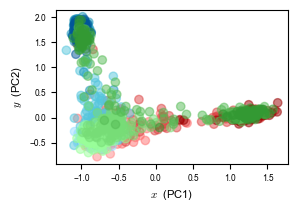

In [25]:
# %matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(3,2))

cmaps = [CMAP1, CMAP2, CMAP3]
legend_handles = []
legend_labels = []
final_transformed_data = np.empty([NSIMS, len(ts_saved), ncells, 2])
for cond_idx, xyz_across_times in enumerate(XS_RESULTS):
    for tidx, (t, xyz) in enumerate(zip(ts_saved, xyz_across_times)):
        uvw = pca.transform(xyz)
        final_transformed_data[cond_idx,tidx,:] = uvw[:,0:2]
        sc = ax.scatter(
            uvw[:,0], uvw[:,1],
            c = t * np.ones(uvw.shape[0]),
            cmap=cmaps[cond_idx],
            vmin=ts_saved[0],
            vmax=ts_saved[-1],
            alpha=0.5,
        )
        # legend_handles.append(sc)
        # legend_labels.append(f"Exp. {cond_idx+1}, t={t:n}")

ax.set_xlabel("$x$  (PC1)")
ax.set_ylabel("$y$  (PC2)")

plt.savefig(f"{OUTDIR}/all_data_pc1_vs_pc2.pdf", bbox_inches='tight', transparent=True)

In [26]:
for outdatdir in [out_traindir, out_validdir]:
    np.savetxt(f"{outdatdir}/nsims.txt", [NSIMS], fmt='%d')
    for i in range(NSIMS):
        simdir = f"{outdatdir}/sim{i}"
        os.makedirs(simdir, exist_ok=True)

        np.save(f"{simdir}/ts.npy", ts_saved)
        np.save(f"{simdir}/xs.npy", final_transformed_data[i])
        np.save(f"{simdir}/sigparams.npy", np.array(SIGPARAMS_LIST[i]))

In [27]:
# Load trained model and plot the inferred landscape

from plnn.io import load_model_from_directory

model, _, _, _, _ = load_model_from_directory(TRAINED_MODEL_DIR)

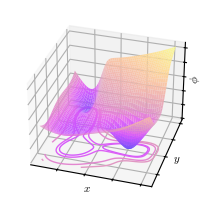

In [28]:
from plnn.pl import plot_phi

figsize = (3, 2.5)

ax = plot_phi(
    model, 
    signal=[0, 1],
    figsize=figsize,
    view_init=[32, -73],
    xrange=[-1.7, 2.1],
    yrange=[-1.4, 2.],
    title='',
    xlabel='', ylabel='', zlabel='',
    plot3d=True,
    show=True,
    include_cbar=False,
    tight_layout=False,
    equal_axes=False,
    ncontours=4,
    alpha=0.95,
);

# ax.set_xticks([-1, 0, 1]);
# ax.set_yticks([-1, 0, 1]);
# ax.set_zticks([0, 1, 2]);
ax.set_xticklabels([]);
ax.set_yticklabels([]);
ax.set_zticklabels([]);
ax.set_xlabel("$x$", labelpad=-15)
ax.set_ylabel("$y$", labelpad=-15)
ax.set_zlabel("$\phi$", labelpad=-15)


plt.savefig(f"{OUTDIR}/landscape.pdf", transparent=True)